In [1]:
%matplotlib inline

import os
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
from scipy import stats

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook")

In [2]:
aa = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,\
      'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,\
      'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}

def count_freq(filepath):
    data = pd.read_csv(filepath, index_col=False, sep=" ")
    binding = data[data.ix[:,2] <= 500]
    freq = np.zeros((20,9))
    for line in binding.ix[:,1]:
        for i, a in enumerate(line):
            try:
                freq[int(aa[a]), i] = freq[aa[a],i]+1
            except KeyError:
                pass
    freq_norm = np.true_divide(freq, 409088)
    freq_norm_r = np.round(freq_norm, 2)
    aa_df = pd.DataFrame(freq_norm_r, index=[i for i in sorted(aa.keys())], columns=np.arange(1,10))
    return aa_df

def plot_freq(aa_df, axes):
#     fig = plt.figure(figsize=(3, 5))
    ax = sns.heatmap(aa_df, ax = axes)
#     plt.show()

def plot_entr(input_df, axes):
    df = pd.DataFrame([stats.entropy(input_df[i], base=2) for i in input_df.columns], columns = ['entropy'])
    df['position'] = input_df.columns
    clrs = ['grey' if x > 3 else 'red' for x in df['entropy']]
#     fig = plt.figure(figsize=(5, 3))
    sns.barplot(data=df, x='position', y='entropy', palette = clrs, ax = axes)

As expected, the two common HLA-B*27 alleles in the European population, B*27:02 (odds ratio (OR)=43; P=1.07 × 10−122) and B*27:05 (OR=62; P<10−321), were the most significantly associated with disease risk (Fig. 1a–b; Tables 1 and 2). Controlling for the effect of the two B*27 alleles, we identified the protective alleles HLA-B*07:02 (OR=0.82; P=5.04 × 10−6) and HLA-B*57:01 (OR=0.75; P=5.13 × 10−4; Table 2)

https://www.nature.com/articles/ncomms8146

In [3]:
# data = pd.read_csv("output/HLA-B27:05_NMP_9mer_proc.txt", index_col=False, sep=" ")
# binding = data[data.ix[:,2] <= 500]
B2705 = count_freq("output/HLA-B27:05_NMP_9mer_proc.txt")
B0702 = count_freq("output/HLA-B07:02_NMP_9mer_proc.txt")

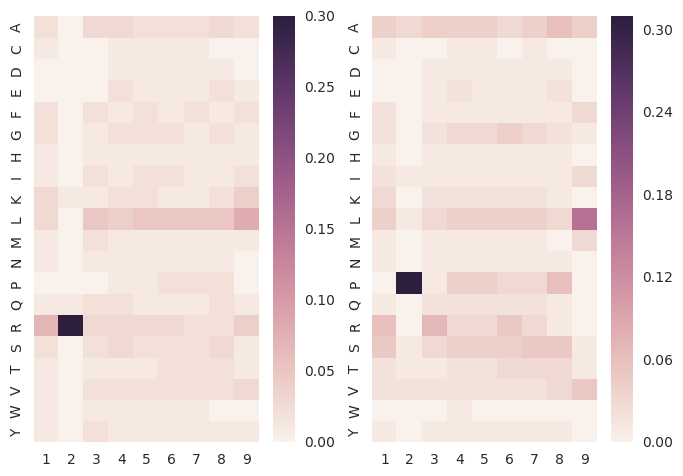

In [4]:
figs, axs = plt.subplots(1,2)

plot_freq(B2705, axs[0])
plot_freq(B0702, axs[1])

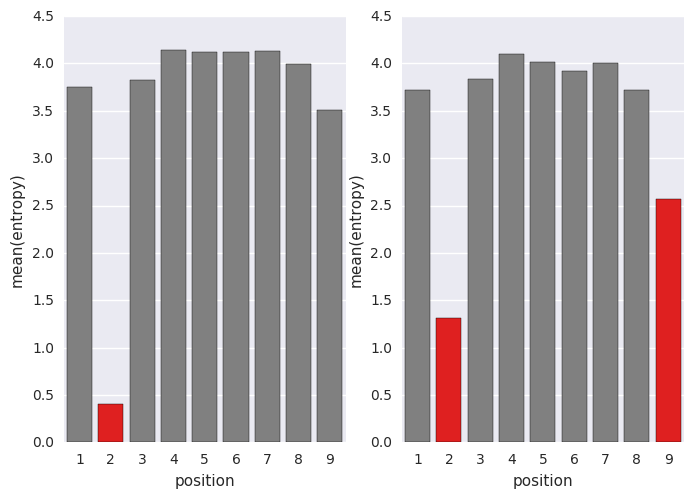

In [5]:
figs, axs = plt.subplots(1,2)

plot_entr(B2705, axs[0])
plot_entr(B0702, axs[1])

In [6]:
sumentrlist = {}
for filename in tqdm_notebook(os.listdir("output/")):
    if "NMP" in filename:
        entr = 0
        name = filename.replace("_NMP_9mer_proc.txt", "").replace("-", "").replace(":", "")
        freq = count_freq("output/" + filename)
        for col in freq:
            entr += stats.entropy(freq[col], base=2)
        sumentrlist[name] = entr

In [7]:
sumentrlist['HLAB1501']

33.495083852971973

In [10]:
data = pd.DataFrame.from_dict(sumentrlist, orient="index")
data['name'] = data.index
data = data.replace([np.inf, -np.inf], np.nan).dropna()
data = data.sort_values(by='name')
data.index = range(len(data))
data.head()

,0,name
0,15.726256,HLAA0101
1,32.863292,HLAA0201
2,33.493891,HLAA0202
3,33.347263,HLAA0203
4,33.473073,HLAA0205


In [9]:
df = pd.read_csv("data/bdata.csv")
df = df[df['species']=='human']
freq = df.mhc.value_counts()
freq.head()

HLAA0201    11920
HLAA0301     7089
HLAA0203     6302
HLAA1101     6255
HLAA3101     5628
Name: mhc, dtype: int64

In [25]:
df = freq[freq.index.isin(data.name)]
df = pd.DataFrame(df)
df['name'] = df.index
df.columns = ['freq', 'name']
df = df.sort_values(by='name')
df.index = range(len(df))
df.head()

,freq,name
0,4558,HLAA0101
1,11920,HLAA0201
2,4155,HLAA0202
3,6302,HLAA0203
4,75,HLAA0205


In [30]:
dfx = pd.concat([data, df], axis=1)
dfx.columns = ["entropy", "allele", "frequency", "delete"]
dfx = dfx.drop('delete', axis=1)
dfx.head()

,entropy,allele,frequency
0,15.726256,HLAA0101,4558.0
1,32.863292,HLAA0201,11920.0
2,33.493891,HLAA0202,4155.0
3,33.347263,HLAA0203,6302.0
4,33.473073,HLAA0205,75.0


/home/vcvetkov/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


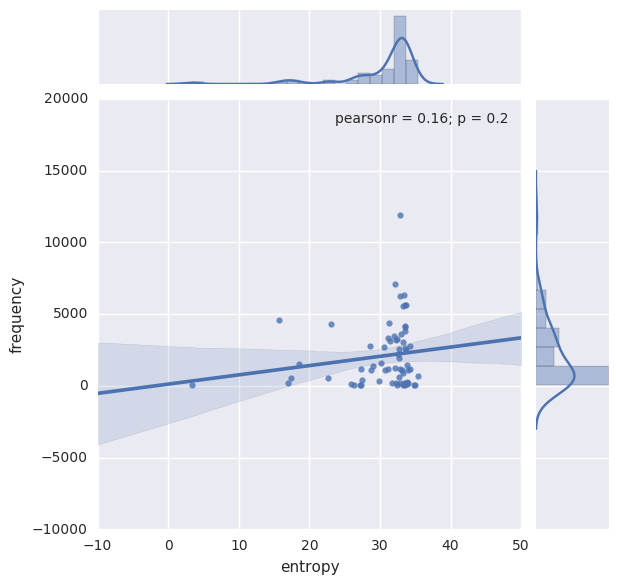

In [31]:
g = sns.jointplot("entropy", "frequency", data=dfx, kind="reg")

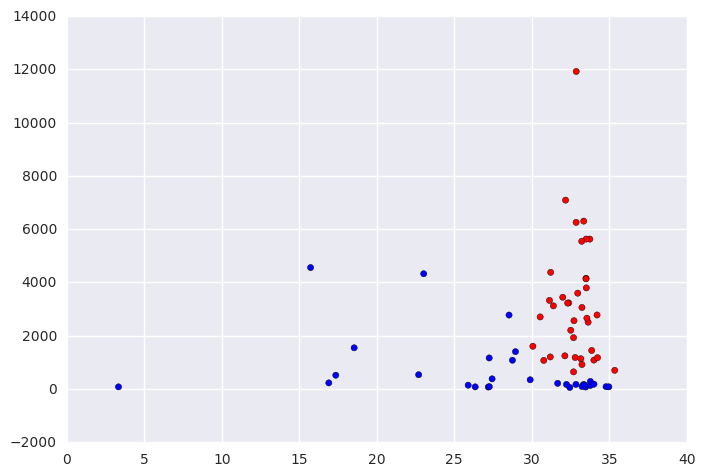

In [50]:
color1 = [1 if dfx.ix[i, 'frequency'] > 500 else 0 for i in dfx.index]
color2 = [1 if dfx.ix[i, 'entropy'] > 30 else 0 for i in dfx.index]
color_i = [k&l for k, l in zip(color1, color2)]
colors = ['r' if i==1 else 'b' for i in color_i]
p = plt.scatter(x = dfx['entropy'], y = dfx['frequency'], c=colors)